## Importing Modules

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)

Num GPUs Available:  0
2.17.0


In [2]:
#pip install h5py

In [3]:
import h5py

In [4]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

## Data Preprocessing and Model construction

In [5]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)# restructuring the model
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [6]:
dir = 'C:/Users/Naman Gupta/OneDrive/Desktop/New folder/Other Projects/Image captioning'

In [7]:
'''features = {}
directory = os.path.join(dir, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # loading the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature'''

"features = {}\ndirectory = os.path.join(dir, 'Images')\n\nfor img_name in tqdm(os.listdir(directory)):\n    # loading the image from file\n    img_path = directory + '/' + img_name\n    image = load_img(img_path, target_size=(224, 224))\n    # convert image pixels to numpy array\n    image = img_to_array(image)\n    # reshape data for model\n    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))\n    # preprocess image for vgg\n    image = preprocess_input(image)\n    # extract features\n    feature = model.predict(image, verbose=0)\n    # get image ID\n    image_id = img_name.split('.')[0]\n    # store feature\n    features[image_id] = feature"

In [8]:
working_directory = 'C:/Users/Naman Gupta/OneDrive/Desktop/New folder/Other Projects/Image captioning'

### saving features extracted from image so that we dont have do it all over again

In [ ]:
pickle.dump(features, open(os.path.join(working_directory, 'features_image.pkl'), 'wb'))

In [9]:
with open(os.path.join(working_directory, 'features_image.pkl'), 'rb') as file:
    features = pickle.load(file)

In [10]:
for key,value in features.items():
    print(key,value)
    break

1000268201_693b08cb0e [[2.5074735 0.        0.        ... 0.        0.        0.       ]]


### now we have to map each caption to its corresponding caption so that we can train our machine learning model


In [11]:
# firstly we will load the captions
with open(os.path.join(dir, 'captions.txt') , 'r') as f:
    next(f)
    captions_document = f.read()
captions_document.split('\n')[:6]

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting']

In [12]:
from PIL import Image
import matplotlib.pyplot as plt

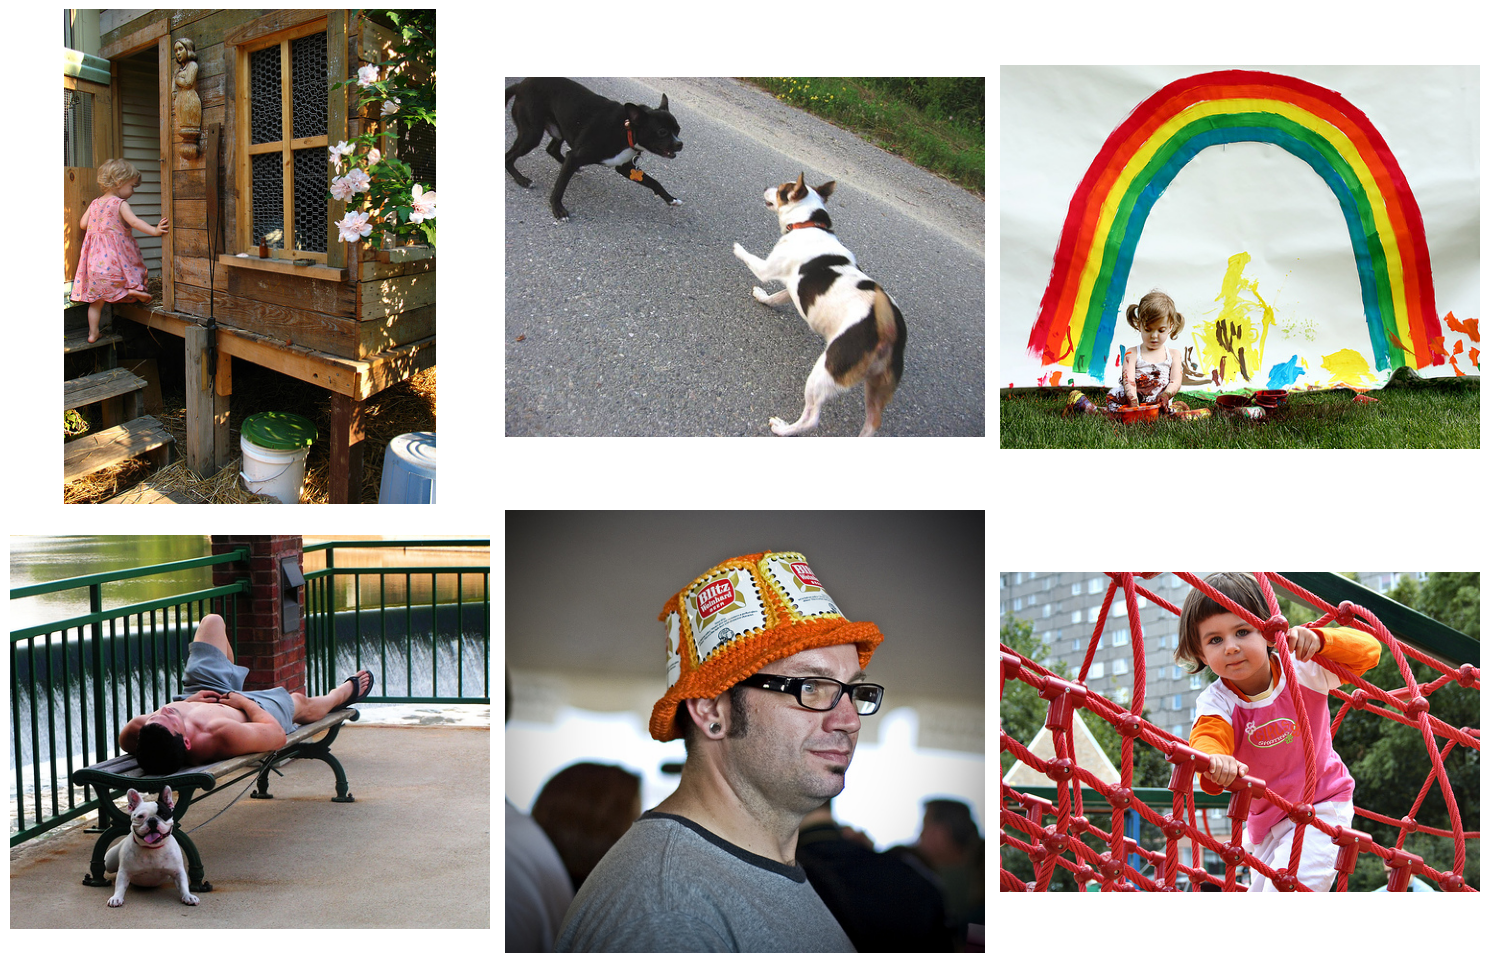

In [13]:
def display_images_grid(directory, num_images=6):
    # Get a list of image filenames in the directory
    image_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Select the first `num_images` images
    selected_images = image_files[:num_images]

    # Create a figure to display the images in a grid
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Iterate over selected images and display them
    for i, image_file in enumerate(selected_images):
        img = Image.open(image_file)
        ax = axes[i // 3, i % 3]  # Calculate grid position
        ax.imshow(img)
        ax.axis('off')  # Hide axes

    # Show the plot
    plt.tight_layout()
    plt.show()
directory_image = 'C:/Users/Naman Gupta/OneDrive/Desktop/New folder/Other Projects/Image captioning/Images'
display_images_grid(directory_image)

In [14]:
# now we need to map the above captions and images to each other
map = {}
for line in tqdm(captions_document.split('\n')):
    token = line.split(',')
    if len(line) < 2:
        continue
    image_id , caption = token[0] , token[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in map:
        map[image_id] = []
    map[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [15]:
len(map) # Total no.of images in the dataset which we are going to use for training the model

8091

In [16]:
for key,value in map.items():
    print(key,value)
    break

1000268201_693b08cb0e ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


### now we will start our preprocessing

In [17]:
def cleaning(map):
    for key, captions in map.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [18]:
cleaning(map)
for key,value in map.items():
    print(key,value)
    break

1000268201_693b08cb0e ['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']


### Now we will tokenize the text

In [19]:
all_captions = []
for key in map:
    for caption in map[key]:
        all_captions.append(caption)
all_captions[:5]
len(all_captions)

40455

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print("No.of distinct words in captions :",vocab_size)

No.of distinct words in captions : 8485


In [21]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

### Train Test and Split of Data

In [22]:
image_ids = list(map.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]
len(train) , len(test)

(7281, 810)

### now we will generate the data 

In [23]:
# In below cell X1----> Image and X2----> Text Y---> output

In [24]:
def data_generator(data_keys, map, features, tokenizer, max_length, vocab_size, batch_size):
    X1 ,X2 ,y = list() ,list() ,list()
    n = 0
    while True:
        for key in data_keys:
            n += 1
            captions = map[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range (1,len(seq)):
                    in_sequence, out_sequence = seq[:i], seq[i]
                    in_sequence = pad_sequences([in_sequence], maxlen = max_length)[0]
                    out_sequence = to_categorical([out_sequence], num_classes = vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_sequence)
                    y.append(out_sequence)
            if n == batch_size:
                X1=np.array(X1)
                X2=np.array(X2)
                y=np.array(y)
                yield(X1,X2), y
                X1 ,X2 ,y = list() ,list() ,list()
                n = 0

## Model

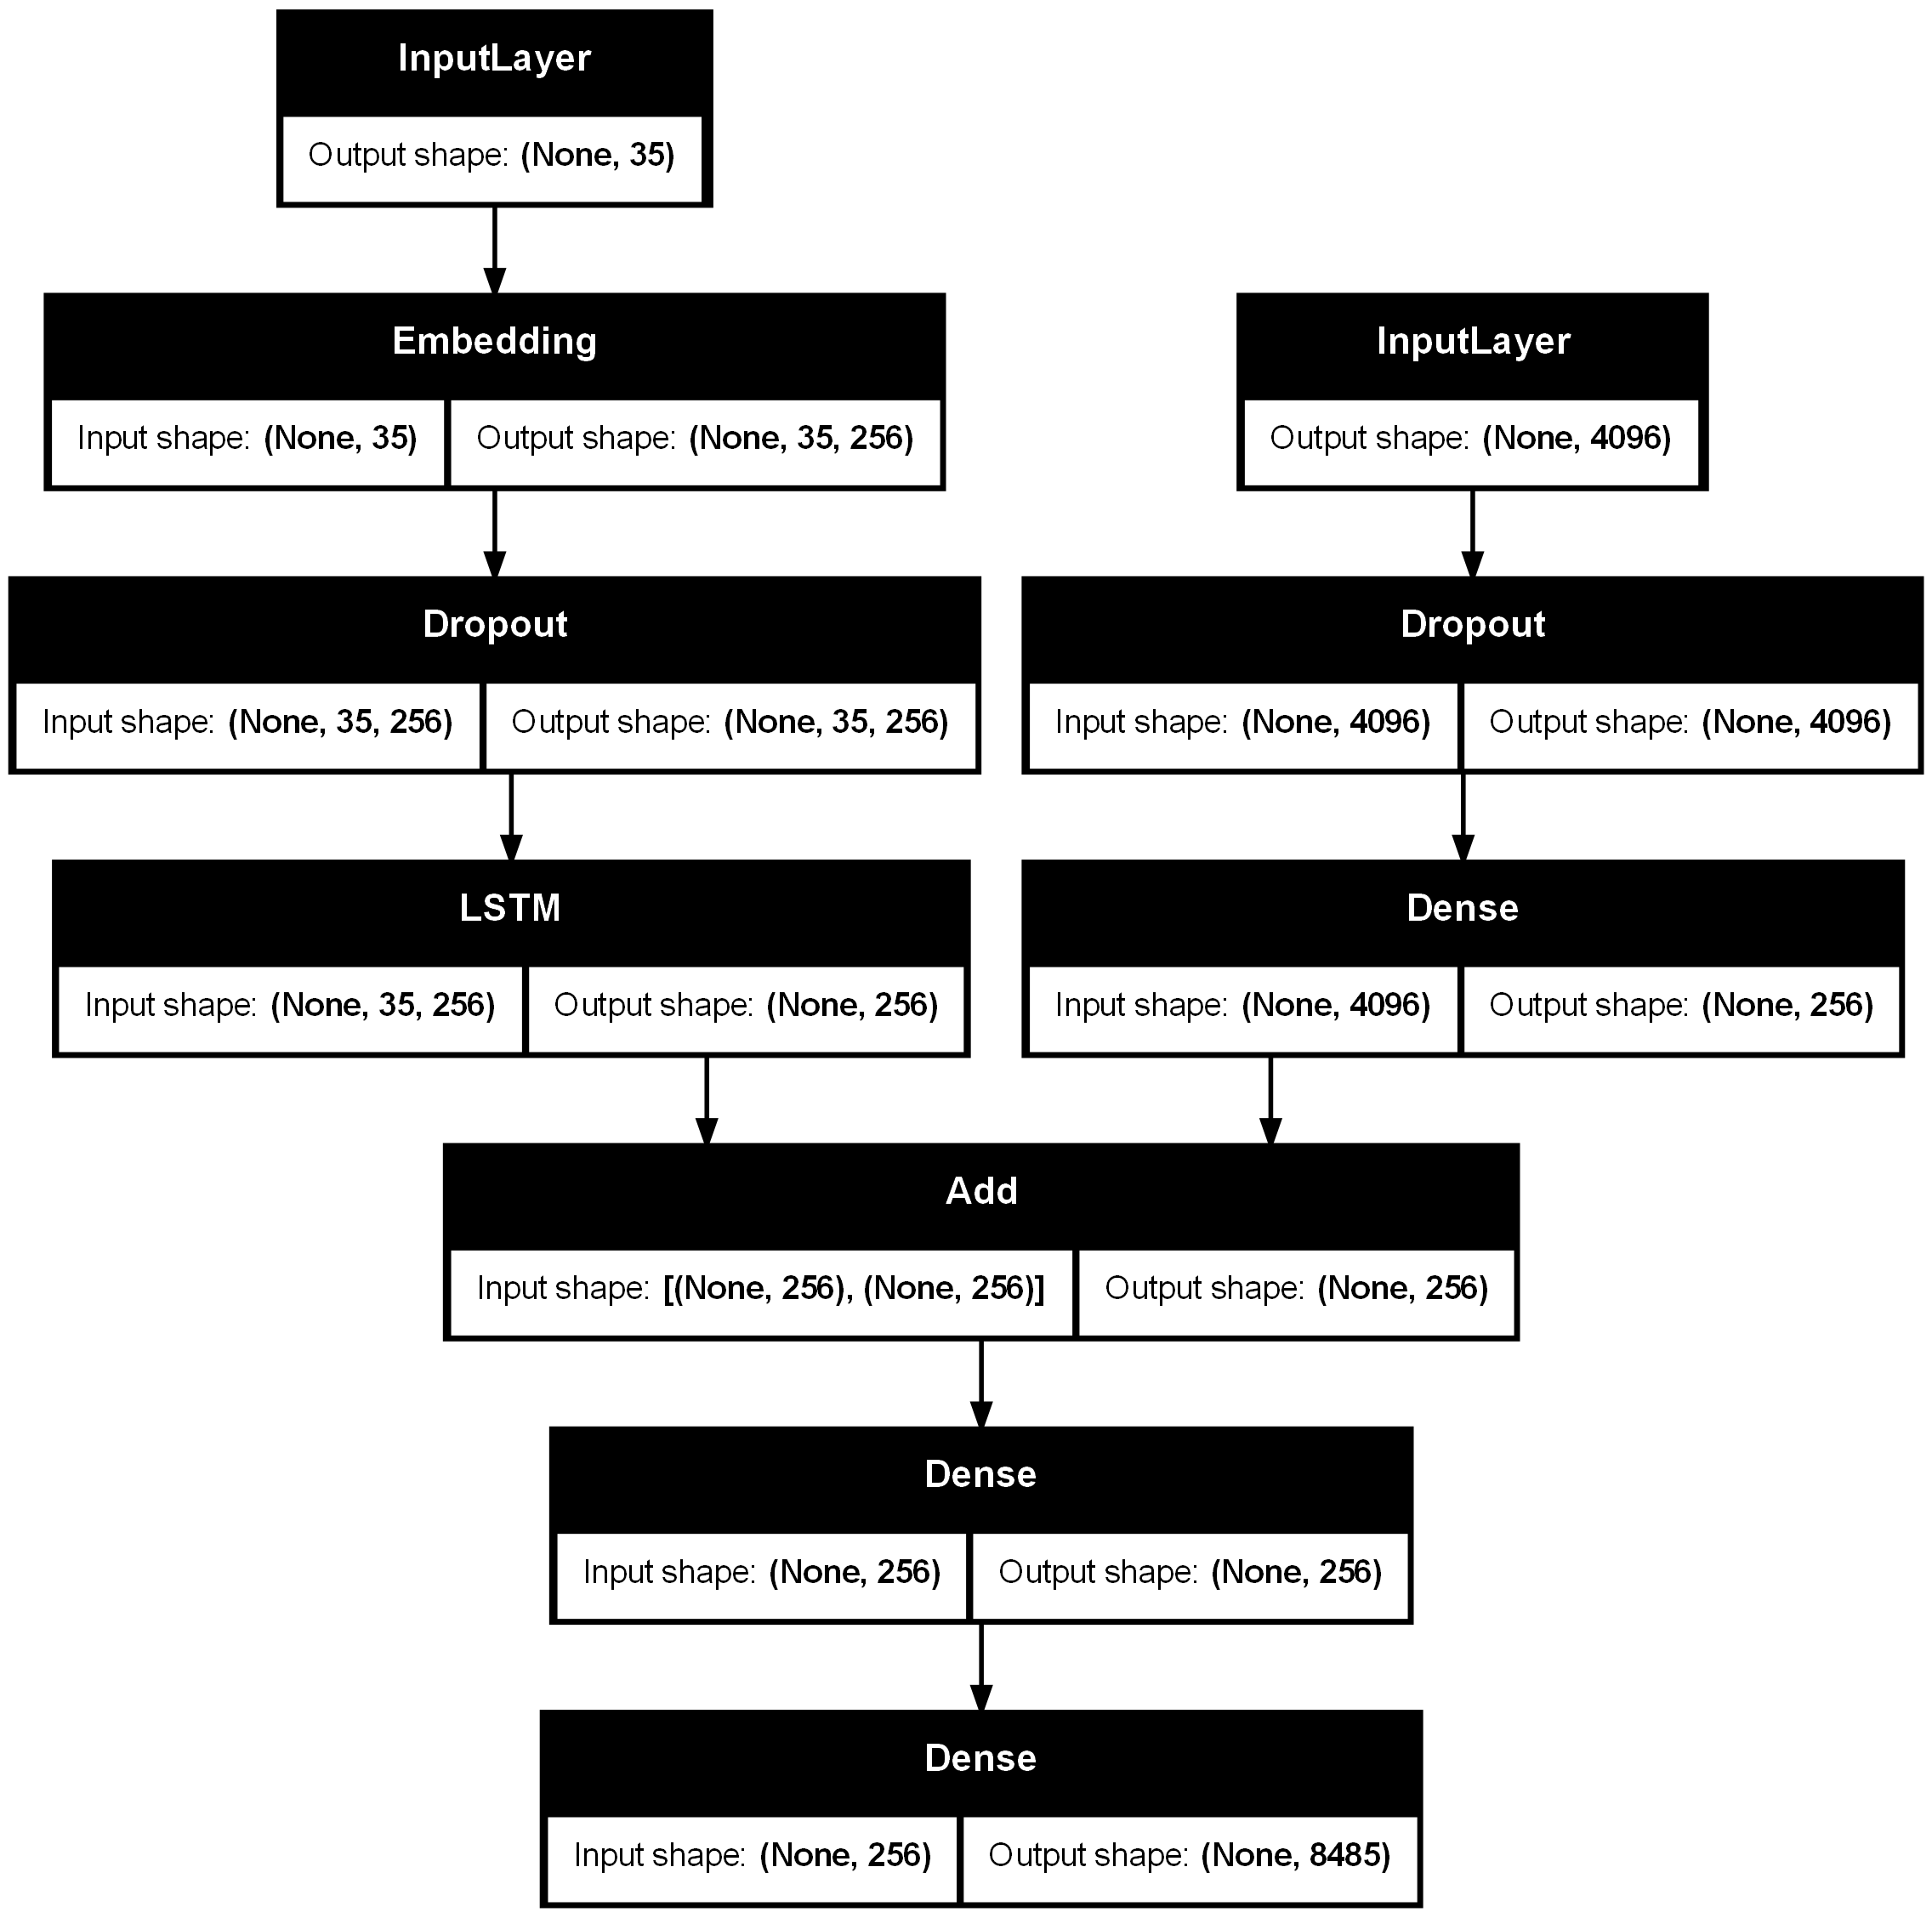

In [25]:
# image processing layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence processing layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=False)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

### Training of model

In [26]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, map, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - loss: 5.7779
227/227 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - loss: 4.0522
227/227 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - loss: 3.5767
227/227 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - loss: 3.2938
227/227 ━━━━━━━━━━━━━━━━━━━━ 279s 1s/step - loss: 3.0904
227/227 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - loss: 2.9316
227/227 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - loss: 2.8165
227/227 ━━━━━━━━━━━━━━━━━━━━ 598s 3s/step - loss: 2.7246
227/227 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - loss: 2.6455
227/227 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - loss: 2.5793
227/227 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - loss: 2.5174
227/227 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - loss: 2.4618
227/227 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - loss: 2.4128
227/227 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - loss: 2.3675
227/227 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - loss: 2.3263
227/227 ━━━━━━━━━━━━━━━━━━━━ 337s 1s/step - loss: 2.2869
227/227 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - loss: 2.2534
227/227 ━━━━━━━━━━━━━━━━━━━━ 32

In [27]:
model.save(dir+'/best_model_4.h5')

In [28]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

## Generate Captions for the Images

In [29]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [30]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [31]:
from nltk.translate.bleu_score import corpus_bleu
# validation of test data|
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = map[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.537785
BLEU-2: 0.316090


In [36]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(dir, "Images", image_name)
    image = Image.open(img_path)
    captions = map[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are wrestling on the beach endseq


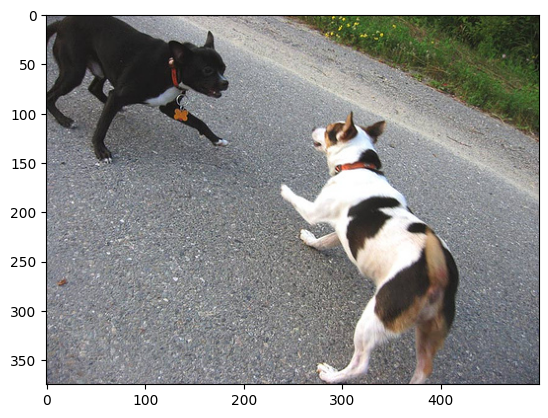

In [37]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq woman wearing red jacket and red jacket is displaying framed pictures in the snow endseq


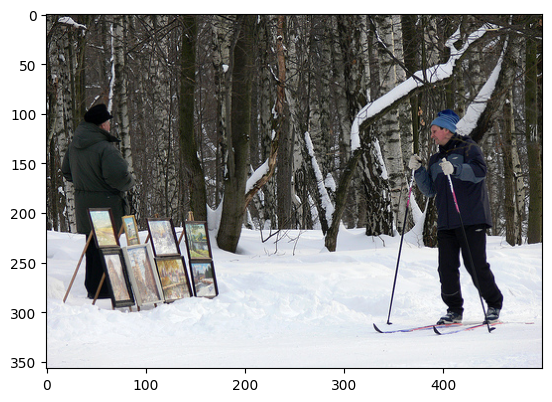

In [38]:
generate_caption("101669240_b2d3e7f17b.jpg")

In [39]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

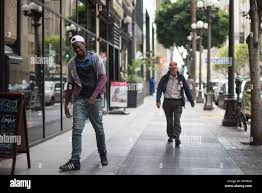

In [51]:
Image.open('C:/Users/Naman Gupta/OneDrive/Desktop/New folder/Other Projects/Image captioning/download.jpeg')

In [42]:
image_path = 'C:/Users/Naman Gupta/OneDrive/Desktop/New folder/Other Projects/Image captioning/download.jpeg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq man in black leather jacket walks down the street endseq'